In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 34.61 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [ ]:
import os
from glob import glob

import torch
import torch.nn as nn
from torch.nn.functional import threshold_
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from PIL import Image
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

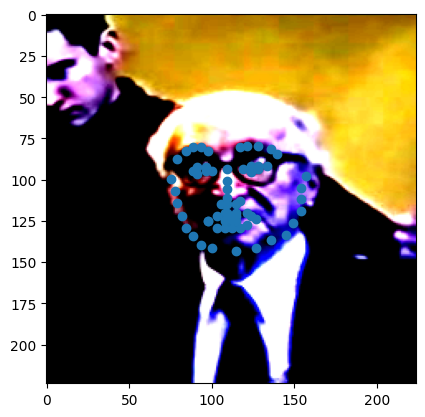

In [ ]:
class FaceDataset(Dataset):
    def __init__(self, x_dir_path, y_file_path):
        self.img_train = glob(os.path.join(x_dir_path, '*.jpg'))
        self.facial_points = pd.read_csv(y_file_path)

        self.img_trans = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Lambda(lambda img: img[:3]),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.img_train)

    def __getitem__(self, item):
        img_path = self.img_train[item]
        img = Image.open(img_path)

        facial_points = self.facial_points[self.facial_points.iloc[:, 0] == os.path.basename(img_path)]
        facial_points_x = pd.to_numeric(facial_points.iloc[0, 1::2])
        facial_points_y = pd.to_numeric(facial_points.iloc[0, 2::2])

        facial_points_y *= (224 / img.height)
        facial_points_x *= (224/ img.width)

        img_t = self.img_trans(img)

        facial_points_x = torch.tensor(facial_points_x.values, dtype=torch.float32).to(device)
        facial_points_y = torch.tensor(facial_points_y.values, dtype=torch.float32).to(device)

        return img_t.to(device), (facial_points_x, facial_points_y)


data_dir = './P1_Facial_Keypoints/data'
trn_dataset = FaceDataset(f'{data_dir}/training', f'{data_dir}/training_frames_keypoints.csv')
val_dataset = FaceDataset(f'{data_dir}/test', f'{data_dir}/test_frames_keypoints.csv')

trn_dataloader = DataLoader(trn_dataset, 128, True)
val_dataloader = DataLoader(val_dataset, 128, True)

img_idx = 10
plt.imshow(trn_dataset[img_idx][0].permute(1,2,0).cpu())
plt.scatter(trn_dataset[img_idx][1][0].cpu(), trn_dataset[img_idx][1][1].cpu())

In [ ]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 98.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for p in model.parameters(): p.requires_grad = False
model.avgpool = nn.AdaptiveAvgPool2d(3)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(4608, 2304),
    nn.BatchNorm1d(2304),
    nn.ReLU(),

    nn.Linear(2304, 768),
    nn.BatchNorm1d(768),
    nn.ReLU(),

    nn.Linear(768, 256),
    nn.BatchNorm1d(256),
    nn.Mish(),

    nn.Linear(256, 136), #first 68 is x, last 68 is y
)

model = model.to(device)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
criterion = nn.L1Loss()
opt = optim.Adam(model.parameters(), lr=1e-1)
schedular = optim.lr_scheduler.ReduceLROnPlateau(
    opt,
    factor=0.8,
    threshold=1e-3
    threshold_mode='rel',
    patience=15,
    min_lr=1e-6,
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-10-5d957e84426a>, line 6)

In [ ]:
epochs = 20

for epoch in range(epochs):
    model.train()
    for img, (facial_x, facial_y) in trn_dataloader:
        img = img.to(device)
        facial_x = facial_x.to(device)
        facial_y = facial_y.to(device)

        _facial = model(img)
        facial = torch.concat([facial_x, facial_y], dim=-1)

        loss = criterion(_facial, facial)

        opt.zero_grad()
        loss.backward()
        opt.step()

        print(f"loss {loss}, LR: {opt.param_groups[0].get('lr')}")

    schedular.step(loss)
    print(f"EPOCH {epoch}")

loss 116.86851501464844, LR: 0.0001
loss 115.0297622680664, LR: 0.0001
loss 114.9229965209961, LR: 0.0001


KeyboardInterrupt: 

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

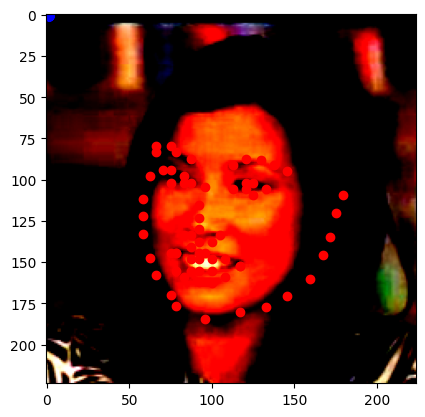

In [ ]:
model.eval()
rand_img, (facial_x, facial_y) = trn_dataset[np.random.randint(0, len(trn_dataset))]
_keypoints = model(rand_img.unsqueeze(0))

rand_img = rand_img.to('cpu')
facial_x = facial_x.to('cpu')
facial_y = facial_y.to('cpu')
_keypoints = _keypoints.to('cpu').detach()[0]
plt.imshow(rand_img.permute(1, 2, 0))
plt.scatter(facial_x, facial_y, color='red')
plt.scatter(_keypoints[:68], _keypoints[68:], color='blue')
